In [1]:
%load_ext autoreload
%autoreload 2

import torch

from text3d2video.utilities.video_util import pil_frames_to_clip
import wandb_util.wandb_util as wbu
from text3d2video.utilities.ipython_utils import display_ims
import torchvision.transforms.functional as TF

torch.set_grad_enabled(False)

In [2]:
from text3d2video.artifacts.anim_artifact import AnimationArtifact
from text3d2video.artifacts.video_artifact import VideoArtifact
from omegaconf import OmegaConf

# deadpool cat
# video_tag = "video:v855" # Deadpool catwalk 180
video_tag = "video:v897" # Deadpool Cat

video = VideoArtifact.from_wandb_artifact_tag(video_tag)
frames = video.read_frames()

# recover animation
gr_run = video.logged_by()
anim = wbu.used_artifacts(gr_run, type="animation")[0]
anim = AnimationArtifact.from_wandb_artifact(anim)
cameras, meshes = anim.load_frames()
verts_uvs, faces_uvs = anim.uv_data()

# recover prompt
prompt = OmegaConf.create(gr_run.config).prompt

In [3]:
from text3d2video.rendering import render_rgb_uv_map
from text3d2video.utilities.video_comparison import display_vids

vid = pil_frames_to_clip(frames)
uvs = pil_frames_to_clip(render_rgb_uv_map(meshes, cameras, verts_uvs, faces_uvs))

display_vids([uvs, vid], width=500, title=prompt)

In [4]:
from text3d2video.pipelines.generative_rendering_pipeline import (
    GenerativeRenderingPipeline
)
from text3d2video.pipelines.pipeline_utils import load_pipeline

sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"
pipe = load_pipeline(GenerativeRenderingPipeline, sd_repo, controlnet_repo)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

# Bring to noise level to simulate denoising

In [8]:
t_index = 3
pipe.scheduler.set_timesteps(10)
t = pipe.scheduler.timesteps[t_index]
print(t)

latents_clean = pipe.encode_images(frames)
noise = torch.randn_like(latents_clean)
latents = pipe.scheduler.add_noise(latents_clean, noise, t)

tensor(601)


In [9]:
from text3d2video.util import ordered_sample_indices
from torch import Tensor

indices = Tensor([0, 1, 2, 3, 4, 5, 6, 7, 8]).long()

latents_sampled = latents[indices]
cameras_sampled = cameras[indices]
meshes_sampled = meshes[indices]


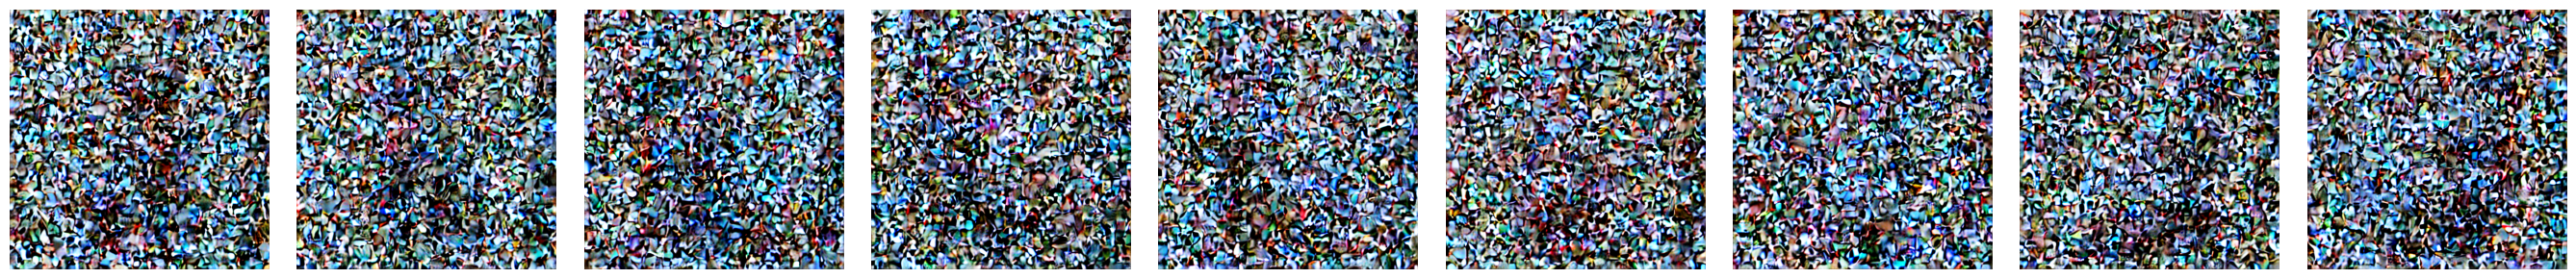

In [10]:
display_ims(pipe.decode_latents(latents_sampled))

In [11]:
from text3d2video.pipelines.method import MethodLogic
method = MethodLogic(pipe)

In [12]:
from text3d2video.rendering import render_depth_map

depths = render_depth_map(meshes_sampled, cameras_sampled)
prompts = [prompt] * len(latents_sampled)
cond_embeddings, uncond_embeddings = pipe.encode_prompt(prompts)

In [13]:
# precompute rasterization and projections
from text3d2video.backprojection import project_visible_texels_to_camera
from text3d2video.rendering import make_mesh_rasterizer

uv_res = 600

projections = []
fragments = []
rasterizer = make_mesh_rasterizer(resolution=64)
for i in range(len(latents_sampled)):
    cam = cameras_sampled[i]
    mesh = meshes_sampled[i]

    # project UVs to camera
    projection = project_visible_texels_to_camera(
        mesh,
        cam,
        verts_uvs,
        faces_uvs,
        texture_res=uv_res,
        raster_res=2000,
    )
    projections.append(projection)

    # rasterize
    frags = rasterizer(mesh, cameras=cameras[i])
    fragments.append(frags)

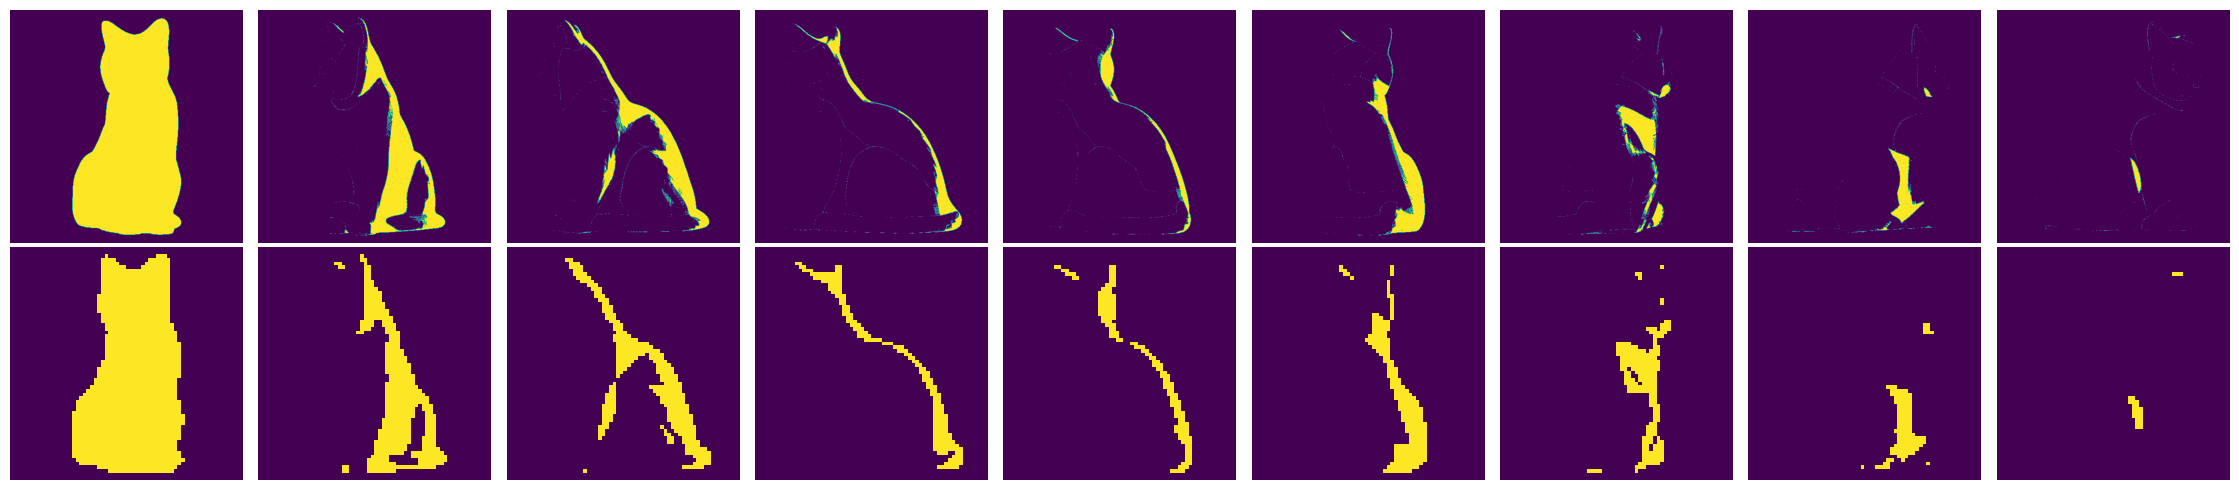

In [14]:
from text3d2video.rendering import compute_newly_visible_masks, downsample_masks
from text3d2video.utilities.ipython_utils import display_ims_grid

newly_visible_masks = compute_newly_visible_masks(
    cameras_sampled,
    meshes_sampled,
    projections,
    uv_res,
    512,
    verts_uvs,
    faces_uvs,
)

newly_visible_masks_down = downsample_masks(newly_visible_masks, (64, 64), thresh=0.08)

display_ims_grid([newly_visible_masks, newly_visible_masks_down])

In [15]:
from text3d2video.utilities.ipython_utils import display_vid

masks_pil = [TF.to_pil_image(m) for m in newly_visible_masks_down]

display_vid(pil_frames_to_clip(masks_pil))

In [16]:
from pathlib import Path
from text3d2video.backprojection import update_uv_texture
from text3d2video.noise_initialization import UVNoiseInitializer
from text3d2video.rendering import render_texture, shade_mesh
from text3d2video.utilities.logging import H5Logger

logger = H5Logger(Path("data.h5"))
logger.delete_data()
logger.open_write()

# initialize clean image texture
clean_tex = torch.zeros(uv_res, uv_res, 3).cuda()

uv_noise = UVNoiseInitializer()
uv_noise.sample_background()
uv_noise.sample_noise_texture()

clean_tex = torch.zeros(uv_res, uv_res, 3).cuda()
latent_tex = torch.zeros(uv_res, uv_res, 4).cuda()

for i in range(len(meshes_sampled)):
    mesh = meshes_sampled[i]
    cam = cameras_sampled[i]
    proj = projections[i]
    frags = fragments[i]
    depth = depths[i]
    latent = latents_sampled[i]
    newly_visible = newly_visible_masks_down[i].cuda()

    # render texture
    rendered = shade_mesh(mesh, frags, clean_tex, verts_uvs, faces_uvs)
    rendered = render_texture(mesh, cam, clean_tex, verts_uvs, faces_uvs)
    rendered_latent = pipe.encode_images(rendered)

    # rendered_latent = render_texture(
    #     mesh,
    #     cam,
    #     latent_tex,
    #     verts_uvs,
    #     faces_uvs,
    #     resolution=64,
    #     sampling_mode="nearest",
    # )

    # bring render to noise level
    noise = uv_noise.initial_noise(mesh, cam, verts_uvs, faces_uvs)
    noise = torch.randn_like(noise)
    rendered_noisy = pipe.scheduler.add_noise(rendered_latent, noise, t)[0]

    mixed_latent = latent * newly_visible + rendered_noisy * (1 - newly_visible)
    mixed_latent = mixed_latent.to(latent)

    # mixed_latent = latent
    mixed_latent = mixed_latent.unsqueeze(0)

    # noise pred
    noise_pred = method.model_forward_guided(
        mixed_latent,
        cond_embeddings[[i]],
        uncond_embeddings[[i]],
        t,
        depth_maps=[depth],
    )

    # get clean image
    clean_im = pipe.scheduler.step(noise_pred, t, mixed_latent).pred_original_sample[0]
    clean_im_rgb = pipe.decode_latents(clean_im.unsqueeze(0), output_type="pt")[0]

    update_uv_texture(clean_tex, clean_im_rgb, proj.xys, proj.uvs)
    update_uv_texture(latent_tex, clean_im, proj.xys, proj.uvs, interpolation="nearest")

    logger.write("clean_im", clean_im_rgb, i=i)

logger.close()
logger.open_read()

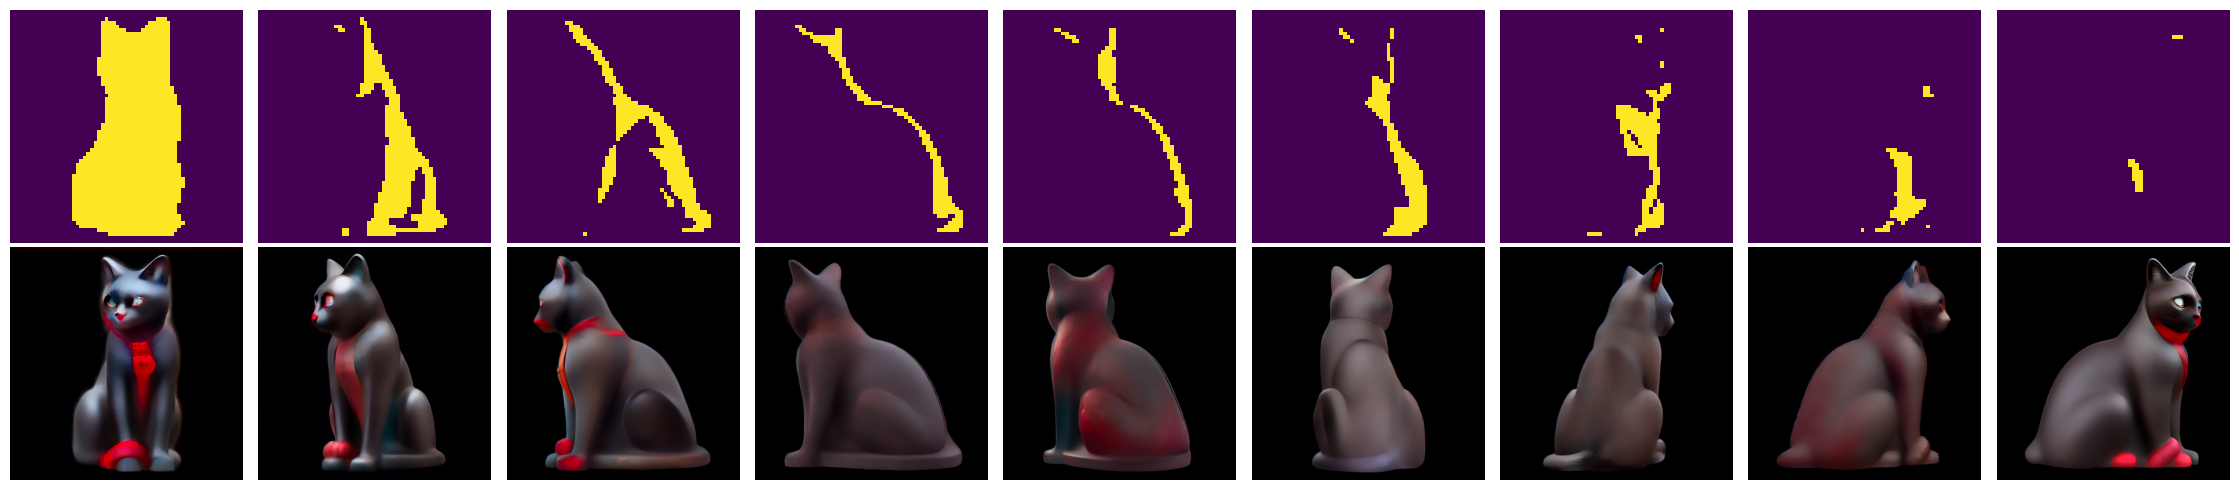

In [21]:
from text3d2video.utilities.ipython_utils import display_ims_grid
import torchvision.transforms.functional as TF

frame_indices = list(range(len(meshes_sampled)))

def read_values(key):
    return [logger.read(key, i=i, transform=TF.to_pil_image) for i in frame_indices]

# renders = read_values("rendered")
clean_ims = read_values("clean_im")

display_ims_grid([newly_visible_masks_down, clean_ims])

In [18]:
from text3d2video.utilities.ipython_utils import display_vid


display_vid(pil_frames_to_clip(clean_ims))

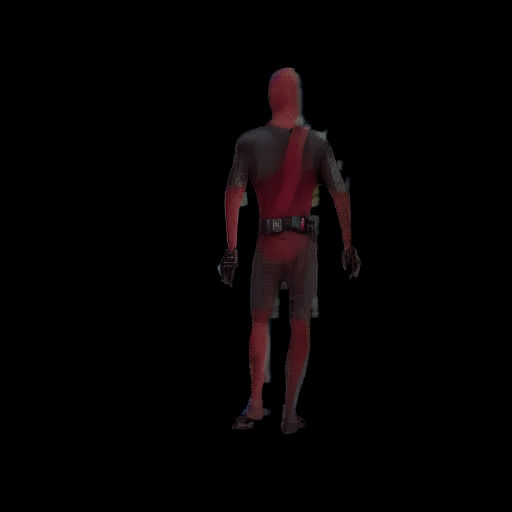

In [182]:
clean_ims[4]